# Forest Land Area (percentage of total land area)
In this notebook we will predict forest land area based on social and governance readiness scores with inspiration from ND-GAIN indicators. 

Overview of the notebook structure
- Cleaning and assessing forest data 
- Log-transforming forest data
- Combining forest data with Predictor data
- Exploring correlations with the predictor data 
- Splitting the combined dataset in training, validation and testing data
    - With our outcome variable (forest) lagged by 5 years
- Fitting baseline model (mean model)
- Fitting simple mixed effects model (time, population)
- Fitting simple mixed effects models with each predictor seperately (time, population predictor_xyzab)
- Fitting theory driven mixed effects model of social (time, population, predictor_x, predictor_y, predictor_z)
- Fitting theory driven mixed effects model of governance (time, population, predictor_x, predictor_y, predictor_z)
- Fitting a mixed effects decision tree model, random forest with all predictors
- Compare model predictions 


In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns

import pickle as pkl

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [4]:
#Read file 
df = pd.read_csv('Data/forest_area_percent.csv', skiprows=4)


In [7]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 69 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            0 non-null      float64
 5   1961            0 non-null      float64
 6   1962            0 non-null      float64
 7   1963            0 non-null      float64
 8   1964            0 non-null      float64
 9   1965            0 non-null      float64
 10  1966            0 non-null      float64
 11  1967            0 non-null      float64
 12  1968            0 non-null      float64
 13  1969            0 non-null      float64
 14  1970            0 non-null      float64
 15  1971            0 non-null      float64
 16  1972            0 non-null      float64
 17  1973            0 non-null      flo

In [11]:

df.describe()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,Unnamed: 68
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.862769,31.797279,31.754538,31.705921,31.656062,31.610967,31.563746,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22.971169,22.917186,22.899194,22.875540,22.852086,22.830212,22.808484,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.921508,11.923789,11.882564,11.832395,11.780793,11.682695,11.723177,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.427988,30.582410,30.580166,30.334764,30.344393,30.308202,30.318655,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,45.911177,45.875123,45.962242,46.139633,46.319885,45.809650,45.698484,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,97.767115,97.694359,97.647564,97.569103,97.490577,97.412115,97.333611,NaN,NaN,NaN


In [16]:
summary = df.describe()

# Get the row corresponding to the count statistic
count_row = summary.loc['count']

# Filter for columns where the count is 0.0
columns_with_zero_count = count_row[count_row == 0.0].index.tolist()

print(columns_with_zero_count)

['1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '2022', '2023', 'Unnamed: 68']


Seems like we only have values from 1990. So we are removing those columns. 

In [24]:
#Removing zero count columns from data
df_90 = df.drop(columns=columns_with_zero_count)

print(df_90)

                    Country Name Country Code                Indicator Name  \
0                          Aruba          ABW  Forest area (% of land area)   
1    Africa Eastern and Southern          AFE  Forest area (% of land area)   
2                    Afghanistan          AFG  Forest area (% of land area)   
3     Africa Western and Central          AFW  Forest area (% of land area)   
4                         Angola          AGO  Forest area (% of land area)   
..                           ...          ...                           ...   
261                       Kosovo          XKX  Forest area (% of land area)   
262                  Yemen, Rep.          YEM  Forest area (% of land area)   
263                 South Africa          ZAF  Forest area (% of land area)   
264                       Zambia          ZMB  Forest area (% of land area)   
265                     Zimbabwe          ZWE  Forest area (% of land area)   

     Indicator Code       1990       1991       199

In [25]:
df_90.describe()


,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
count,218.000000,222.000000,251.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,254.000000,...,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000,262.000000
mean,32.856441,33.554483,33.103147,33.002867,32.992832,32.944296,32.895509,32.846198,32.821598,32.772673,...,31.985581,31.942172,31.901776,31.862769,31.797279,31.754538,31.705921,31.656062,31.610967,31.563746
std,24.574032,24.986089,24.079624,23.913098,23.892300,23.833131,23.776234,23.721331,23.688899,23.637843,...,23.075606,23.034439,23.001998,22.971169,22.917186,22.899194,22.875540,22.852086,22.830212,22.808484
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.880879,12.914279,12.757912,12.675697,12.607303,12.538909,12.464662,12.402121,12.333727,12.287140,...,11.927941,11.812931,11.867219,11.921508,11.923789,11.882564,11.832395,11.780793,11.682695,11.723177
50%,29.842078,30.371049,31.218556,31.123515,31.316098,31.280093,31.579265,31.553551,31.489039,31.348927,...,30.319328,30.359705,30.367130,30.427988,30.582410,30.580166,30.334764,30.344393,30.308202,30.318655
75%,50.367952,52.181373,48.894391,48.263310,48.173347,48.107819,48.076107,47.714775,47.417713,47.484942,...,46.688549,46.079384,45.913536,45.911177,45.875123,45.962242,46.139633,46.319885,45.809650,45.698484
max,98.574551,98.550987,98.527423,98.503859,98.480295,98.456731,98.433167,98.409603,98.386038,98.362474,...,97.952462,97.890679,97.828897,97.767115,97.694359,97.647564,97.569103,97.490577,97.412115,97.333611


In [26]:

df_90.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 36 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1990            218 non-null    float64
 5   1991            222 non-null    float64
 6   1992            251 non-null    float64
 7   1993            254 non-null    float64
 8   1994            254 non-null    float64
 9   1995            254 non-null    float64
 10  1996            254 non-null    float64
 11  1997            254 non-null    float64
 12  1998            254 non-null    float64
 13  1999            254 non-null    float64
 14  2000            256 non-null    float64
 15  2001            256 non-null    float64
 16  2002            256 non-null    float64
 17  2003            256 non-null    flo

In [30]:
print(df_90)

                    Country Name Country Code                Indicator Name  \
0                          Aruba          ABW  Forest area (% of land area)   
1    Africa Eastern and Southern          AFE  Forest area (% of land area)   
2                    Afghanistan          AFG  Forest area (% of land area)   
3     Africa Western and Central          AFW  Forest area (% of land area)   
4                         Angola          AGO  Forest area (% of land area)   
..                           ...          ...                           ...   
261                       Kosovo          XKX  Forest area (% of land area)   
262                  Yemen, Rep.          YEM  Forest area (% of land area)   
263                 South Africa          ZAF  Forest area (% of land area)   
264                       Zambia          ZMB  Forest area (% of land area)   
265                     Zimbabwe          ZWE  Forest area (% of land area)   

     Indicator Code       1990       1991       199

Make the wide df long instead

In [34]:
melted_df = pd.melt(df_90, id_vars=['Country Code', 'Country Name', 'Indicator Name', 'Indicator Code'], var_name='Year', value_name='Value')

print(melted_df)

     Country Code                 Country Name                Indicator Name  \
0             ABW                        Aruba  Forest area (% of land area)   
1             AFE  Africa Eastern and Southern  Forest area (% of land area)   
2             AFG                  Afghanistan  Forest area (% of land area)   
3             AFW   Africa Western and Central  Forest area (% of land area)   
4             AGO                       Angola  Forest area (% of land area)   
...           ...                          ...                           ...   
8507          XKX                       Kosovo  Forest area (% of land area)   
8508          YEM                  Yemen, Rep.  Forest area (% of land area)   
8509          ZAF                 South Africa  Forest area (% of land area)   
8510          ZMB                       Zambia  Forest area (% of land area)   
8511          ZWE                     Zimbabwe  Forest area (% of land area)   

      Indicator Code  Year      Value  

In [39]:
melted_df.info()
#year needs to be numeric

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8512 entries, 0 to 8511
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Code    8512 non-null   object 
 1   Country Name    8512 non-null   object 
 2   Indicator Name  8512 non-null   object 
 3   Indicator Code  8512 non-null   object 
 4   Year            8512 non-null   float64
 5   Value           8176 non-null   float64
dtypes: float64(2), object(4)
memory usage: 399.1+ KB


In [38]:
melted_df['Year'] = melted_df['Year'].astype(float)

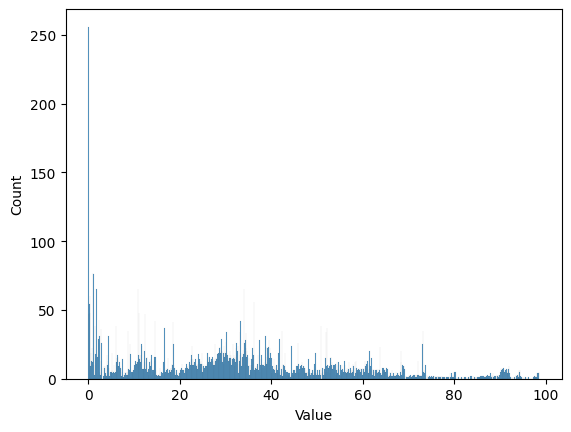

In [51]:
sns.histplot(data=melted_df, x='Value', binwidth=0.1)
plt.show()

We can see that we have countries that have 0 percent, which probably just is an indicator of not being able to record forest areas. 

In [52]:
#Making a list for all countries that have exactly 0.0 percent forest. 

zero_countries = melted_df.groupby('Country Name')['Value'].sum()

zero_countries = zero_countries[zero_countries == 0.0].index.tolist()

print(zero_countries)

['Gibraltar', 'Hong Kong SAR, China', 'Kosovo', 'Macao SAR, China', 'Monaco', 'Nauru', 'Not classified', 'Qatar']


We also do see a lot of names that are not countries. So we filter those out as well. 

In [ ]:
#Filtering out regions and non-countries and zero values as well. 